# Exploring key predictors of CS enrollment in Washington state

## Abstract

We will be using the data table at https://github.com/lgtanimoto/WAStateCSEd/blob/main/2022/2022_school_pt.csv created from the 2021-22 CSEd Summary Report published by OSPI which shows for each high school, how many students, how many student enrollments, how many male students, how many male student enrollments, how many female students, how many female student enrollments, how many gender X, how many gender X enrollments, and does similar info for race/ethnicity, FRL status, ELL status, disability status.   Cross-sectional data (e.g. how many black female enrollments) is not available. With this data we will generate 300,000 random student records and then perform PCA analysis to discover key predictors of CS enrollment in Washington state.


### I. Introduction
### II. **Preprocessing**
### II. **Methodology** 
   #### II.A. Preprocessing
   #### II.B. Generating Synthetic Student Data
   #### II.C. Analysis of Synthetic Student Data
### III. **Results**
### IV. **Conclusion**

# Introduction

Here I will elaborate on the problem at hand.

# Methodology

## Preprocessing

First, we need to import the libraries we will need to explore and analyze this data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import datasets
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from io import StringIO  
from IPython.display import Image  
import pydotplus
import warnings
warnings.filterwarnings('ignore')

Then we will upload the data that we will be using to generate random student records.

In [2]:
ospi_data = pd.read_csv('2022_school_pt.csv',  index_col=0)

Let's take a look at the first few records from the csv file to better understand the school records we are working with.

In [3]:
ospi_data.head()

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,...,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12
0,1109,3075,28,3,9,0,19,3,0,0,...,26,3,7,0,4,0,6,1,11,2
1,1147,3015,1281,169,635,60,646,109,0,0,...,1086,140,382,51,328,44,321,29,250,45
2,1158,2903,60,22,30,12,29,10,1,0,...,57,21,18,12,15,2,14,2,13,6
3,1160,2132,113,24,57,13,56,11,0,0,...,107,20,32,7,35,5,25,4,21,8
4,2250,1617,167,0,89,0,78,0,0,0,...,142,0,16,0,51,0,41,0,59,0


The following code block is searching for missing values.

In [4]:
num_missing_val = ospi_data.isnull().sum()
num_missing_val.sum()

0

There are no missing values. The next step will be the generation of 300,000 random student records with the help of numpy.

To do this, we need to gather the probabilities implied by the given dataset. These probabilities need to be calculated from each of the columns--comparing the total number of students belonging to each feature category to the number that enrolled in a CS course. We also need to find probabilities for which category a single student will belong to.

Calculating the ratio of all students who enroll in CS:

In [5]:
sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)

0.07654341235652434

This shows that about 7.65% of all students in this dataset enrolled in CS. 

## Synthetic Student Generation 

Generation of student records is divided into two approaches:

1. **Without Consideration for School**: This method creates students using probabilities implied by the overall dataset, not using probabilities partitioned by school. 
2. **With Consideration for School**: This method creates students using probabilities by each school. This means that each school will have different probabilities for each student demographic (gender, race, income level, etc) as well as CS enrollment. 

### Without Consideration for School

Finding probabilities for which demographic a student will belong to:

In [6]:
Prob_G_Female = sum(ospi_data.G_Female) / sum(ospi_data.AllStudents)
Prob_G_Male = sum(ospi_data.G_Male) / sum(ospi_data.AllStudents)
Prob_G_GenderX = sum(ospi_data.G_GenderX) / sum(ospi_data.AllStudents)
Prob_R_Native = sum(ospi_data.R_Native) / sum(ospi_data.AllStudents)
Prob_R_Asian = sum(ospi_data.R_Asian) / sum(ospi_data.AllStudents)
Prob_R_Black = sum(ospi_data.R_Black) / sum(ospi_data.AllStudents)
Prob_R_Hisp_Lat = sum(ospi_data.R_Hisp_Lat) / sum(ospi_data.AllStudents)
Prob_R_HPI = sum(ospi_data.R_HPI) / sum(ospi_data.AllStudents)
Prob_R_NA = sum(ospi_data.R_NA) / sum(ospi_data.AllStudents)
Prob_R_TwoOrMore = sum(ospi_data.R_TwoOrMore) / sum(ospi_data.AllStudents)
Prob_R_White = sum(ospi_data.R_White) / sum(ospi_data.AllStudents)
Prob_L_ELL = sum(ospi_data.L_ELL) / sum(ospi_data.AllStudents)
Prob_I_LowIncome = sum(ospi_data.I_LowIncome) / sum(ospi_data.AllStudents)
Prob_I_NoLowIncome = sum(ospi_data.I_NoLowIncome) / sum(ospi_data.AllStudents)
Prob_D_Disability = sum(ospi_data.D_Disability) / sum(ospi_data.AllStudents)
Prob_D_NoDisability = sum(ospi_data.D_NoDisability) / sum(ospi_data.AllStudents)
Prob_A_9 = sum(ospi_data.A_9) / sum(ospi_data.AllStudents)
Prob_A_10 = sum(ospi_data.A_10) / sum(ospi_data.AllStudents)
Prob_A_11 = sum(ospi_data.A_11) / sum(ospi_data.AllStudents)
Prob_A_12 = sum(ospi_data.A_12) / sum(ospi_data.AllStudents)

Finding probability of CS enrollment based on demographic:

In [7]:
Prob_GC_Female = sum(ospi_data.GC_Female) / sum(ospi_data.G_Female)
Prob_GC_Male = sum(ospi_data.GC_Male) / sum(ospi_data.G_Male)
Prob_GC_GenderX = sum(ospi_data.GC_GenderX) / sum(ospi_data.G_GenderX)
Prob_RC_Native = sum(ospi_data.RC_Native) / sum(ospi_data.R_Native)
Prob_RC_Asian = sum(ospi_data.RC_Asian) / sum(ospi_data.R_Asian)
Prob_RC_Black = sum(ospi_data.RC_Black) / sum(ospi_data.R_Black)
Prob_RC_Hisp_Lat = sum(ospi_data.RC_Hisp_Lat) / sum(ospi_data.R_Hisp_Lat)
Prob_RC_HPI = sum(ospi_data.RC_HPI) / sum(ospi_data.R_HPI)
Prob_RC_NA = sum(ospi_data.RC_NA) / sum(ospi_data.R_NA)
Prob_RC_TwoOrMore = sum(ospi_data.RC_TwoOrMore) / sum(ospi_data.R_TwoOrMore)
Prob_RC_White = sum(ospi_data.RC_White) / sum(ospi_data.R_White)
Prob_LC_ELL = sum(ospi_data.LC_ELL) / sum(ospi_data.L_ELL)
Prob_LC_NoELL = sum(ospi_data.LC_NoELL) / sum(ospi_data.L_NoELL)
Prob_IC_LowIncome = sum(ospi_data.IC_LowIncome) / sum(ospi_data.I_LowIncome)
Prob_IC_NoLowIncome = sum(ospi_data.IC_NOLowIncome) / sum(ospi_data.I_NoLowIncome)
Prob_DC_Disability = sum(ospi_data.DC_Disability) / sum(ospi_data.D_Disability)
Prob_DC_NoDisability = sum(ospi_data.DC_NoDisability) / sum(ospi_data.D_NoDisability)
Prob_AC_9 = sum(ospi_data.AC_9) / sum(ospi_data.A_9)
Prob_AC_10 = sum(ospi_data.AC_10) / sum(ospi_data.A_10)
Prob_AC_11 = sum(ospi_data.AC_11) / sum(ospi_data.A_11)
Prob_AC_12 = sum(ospi_data.AC_12) / sum(ospi_data.A_12)

Pausing to compare probability of CS enrollment between genders:

In [8]:
print(Prob_GC_Female)
print(Prob_GC_Male)
print(Prob_GC_GenderX)

0.04510418114369407
0.10592888529774107
0.07277526395173455


These numbers suggest that there's more than double the probability that a male student will enroll in a CS course versus a female student. Also interesting to note is that a student identifying as GenderX appears to have a higher probability of enrolling than a female student. However, this probability may not be completely realistic because there are far fewer students who identify as GenderX, compared to male or female. This disparity will inform future feature engineering.

In [9]:
print(sum(ospi_data.G_Female))
print(sum(ospi_data.G_Male))
print(sum(ospi_data.G_GenderX))

187078
200493
2652


Using these probabilities to begin creating a synthetic dataset of student records:

In [10]:
rng = np.random.default_rng(seed=2023)

# How many student records we want to generate

num_students = 400000

# Load and normalize probabilities
# Gender

g_probs = np.array([Prob_G_Female, Prob_G_Male, Prob_G_GenderX])
g_probs /= np.sum(g_probs)

# Race

r_probs = np.array([Prob_R_Native, Prob_R_Asian, Prob_R_Black, Prob_R_Hisp_Lat, Prob_R_HPI, Prob_R_NA, Prob_R_TwoOrMore, Prob_R_White])
r_probs /= np.sum(r_probs)

# ELL

e_probs = np.array([1-Prob_L_ELL, Prob_L_ELL])

# Income

i_probs = np.array([Prob_I_NoLowIncome, Prob_I_LowIncome])

# Disability

d_probs = np.array([Prob_D_NoDisability, Prob_D_Disability])

# Grade

a_probs = np.array([Prob_A_9, Prob_A_10, Prob_A_11, Prob_A_12])
a_probs /= np.sum(a_probs)

# Generate values for categorical attributes

rng3 = np.random.default_rng(seed=1234)
gender = rng3.choice(['female', 'male', 'x'], size = num_students, p = g_probs)
race = rng3.choice(['Native', 'Asian', 'Black', 'Hisp_Lat', 'HPI', 'NA', 'TwoOrMore', 'White'], size = num_students, p = r_probs)
ell = rng3.choice([0, 1], size = num_students, p = e_probs)
income = rng3.choice([0, 1], size = num_students, p = i_probs)
disability = rng3.choice([0, 1], size = num_students, p = d_probs)
grade = rng3.choice(['9', '10', '11', '12'], size = num_students, p = a_probs)

Creating a dataframe for synthesized student records:

In [11]:
synth_students = pd.DataFrame()
synth_students.insert(0, "Gender", gender, True)
synth_students.insert(1, "Race", race, True)
synth_students.insert(2, "ELL", ell, True)
synth_students.insert(3, "Low Income", income, True)
synth_students.insert(4, "Disability", disability, True)
synth_students.insert(5, "Grade", grade, True)

Viewing synthetic records:

In [12]:
synth_students.head()

,Gender,Race,ELL,Low Income,Disability,Grade
0,male,Hisp_Lat,0,0,1,10
1,female,Hisp_Lat,0,0,0,10
2,male,Hisp_Lat,0,0,0,9
3,female,White,0,1,0,9
4,female,White,0,1,0,9


### CS Enrollment Generation

Next: generating the probability of a demographic enrolling in CS by calculating whether or not the synthesized student is enrolled in CS.

The first step in this process is converting all of the demographic column values into probabilities that the synthetic student will be enrolled in CS. E.g. if a column value is "Hisp_Lat" then it is replaced with the variable "Prob_RC_Hisp_Lat."

In [13]:
ell_df = synth_students[['ELL']].copy()

In [14]:
ell_df.replace(1, Prob_LC_ELL, inplace=True)

In [15]:
zero_prob = Prob_LC_NoELL
ell_df.replace(0, zero_prob, inplace=True)

In [16]:
gend_df = synth_students[['Gender']].copy()
race_df = synth_students[['Race']].copy()
inc_df = synth_students[['Low Income']].copy()
dis_df = synth_students[['Disability']].copy()
gr_df = synth_students[['Grade']].copy()

In [17]:
gend_df.replace('male', Prob_GC_Male, inplace=True)
gend_df.replace('female', Prob_GC_Female, inplace=True)
gend_df.replace('x', Prob_GC_GenderX, inplace=True)

In [18]:
race_df.replace('Native', Prob_RC_Native, inplace=True)
race_df.replace('Asian', Prob_RC_Asian, inplace=True)
race_df.replace('Black', Prob_RC_Black, inplace=True)
race_df.replace('Hisp_Lat', Prob_RC_Hisp_Lat, inplace=True)
race_df.replace('HPI', Prob_RC_HPI, inplace=True)
race_df.replace('NA', Prob_RC_NA, inplace=True)
race_df.replace('TwoOrMore', Prob_RC_TwoOrMore, inplace=True)
race_df.replace('White', Prob_RC_White, inplace=True)

In [19]:
inc_df.replace(0, Prob_IC_NoLowIncome, inplace=True)
inc_df.replace(1, Prob_IC_LowIncome, inplace=True)

In [20]:
dis_df.replace(0, Prob_DC_NoDisability, inplace=True)
dis_df.replace(1, Prob_DC_Disability, inplace=True)

In [21]:
gr_df.replace('9', Prob_AC_9, inplace=True)
gr_df.replace('10', Prob_AC_10, inplace=True)
gr_df.replace('11', Prob_AC_11, inplace=True)
gr_df.replace('12', Prob_AC_12, inplace=True)

In [22]:
calc_prob = pd.DataFrame()
calc_prob["Gender"] = gend_df
calc_prob["Race"] = race_df
calc_prob["ELL"] = ell_df
calc_prob["Income"] = inc_df
calc_prob["Disability"] = dis_df
calc_prob["Grade"] = gr_df
calc_prob.head()

,Gender,Race,ELL,Income,Disability,Grade
0,0.105929,0.066245,0.078064,0.083896,0.056698,0.079958
1,0.045104,0.066245,0.078064,0.083896,0.079513,0.079958
2,0.105929,0.066245,0.078064,0.083896,0.079513,0.103522
3,0.045104,0.072356,0.078064,0.067853,0.079513,0.103522
4,0.045104,0.072356,0.078064,0.067853,0.079513,0.103522


### Three Methodologies for CS Enrollment Column

Data for conditional probabilities is missing from the original dataset--the probability of whether or not a student enrolls in CS for one feature, but not multiple features. No cross-sectional or intersectional data is available. Three methodologies have been created to replicate the effects of intersectionality on CS enrollment. All three will be applied and then the results will be evaluated.

The first method created applies the minimum probability from the probabilities associated with each demographic category of the synthetic student to CS enrollment.

In [23]:
rng4 = np.random.default_rng(seed=3141)

In [24]:
def calc_m1_prob(row):
    return min(row['Gender'], row['Race'], row['ELL'], row['Income'], row['Disability'], row['Grade'])

calc_prob['M1_Prob'] = calc_prob.apply(calc_m1_prob, axis=1)

def is_cs_m1(prob):
    return rng4.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M1'] = calc_prob['M1_Prob'].apply(is_cs_m1)

The second method applies the probability that any student is enrolled in CS to every student, not taking features into account.

In [25]:
Prob_All = sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents)
a_probs = np.array([1-Prob_All, Prob_All])
CS_M2 = rng4.choice([0, 1], size = num_students, p = a_probs)
calc_prob.insert(8, "CS_M2", CS_M2, True)

A third method is applying the average of the probabilities taken from the synthesized student's features.

In [26]:
def calc_m3_prob(row):
    return (row['Gender'] + row['Race'] + row['ELL'] + row['Income'] + row['Disability'] + row['Grade']) / 6


calc_prob['M3_Prob'] = calc_prob.apply(calc_m3_prob, axis=1)


def is_cs_m3(prob):
    return rng4.choice([0, 1], p=[1 - prob, prob])

calc_prob['CS_M3'] = calc_prob['M3_Prob'].apply(is_cs_m3)

Comparing the different percentages of CS enrollment between methods and the sample data.

In [27]:
pct_All_CS_synth1 = f"{sum(calc_prob['CS_M1']) / num_students:%}"
pct_All_CS_synth2 = f"{sum(calc_prob['CS_M2']) / num_students:%}"
pct_All_CS_synth3 = f"{sum(calc_prob['CS_M3']) / num_students:%}"
pct_All_CS_ospi = f"{sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents):%}"
print("Method 1:", pct_All_CS_synth1)
print("Method 2:",pct_All_CS_synth2)
print("Method 3:",pct_All_CS_synth3)
print("OSPI Data:",pct_All_CS_ospi)

Method 1: 5.464000%
Method 2: 7.707250%
Method 3: 7.618000%
OSPI Data: 7.654341%


Method 2 and Method 3 appear to yield the closest results. We will conduct analysis using both methods and compare to see if the relationship between demographics and CS enrollment used in Method 3 increases value in our analysis.

In [28]:
all_synth = pd.concat([synth_students, calc_prob], axis=1)
all_synth.head(5)

,Gender,Race,ELL,Low Income,Disability,Grade,Gender,Race,ELL,Income,Disability,Grade,M1_Prob,CS_M1,CS_M2,M3_Prob,CS_M3
0,male,Hisp_Lat,0,0,1,10,0.105929,0.066245,0.078064,0.083896,0.056698,0.079958,0.056698,0,0,0.078465,0
1,female,Hisp_Lat,0,0,0,10,0.045104,0.066245,0.078064,0.083896,0.079513,0.079958,0.045104,0,0,0.072130,0
2,male,Hisp_Lat,0,0,0,9,0.105929,0.066245,0.078064,0.083896,0.079513,0.103522,0.066245,0,0,0.086195,0
3,female,White,0,1,0,9,0.045104,0.072356,0.078064,0.067853,0.079513,0.103522,0.045104,0,0,0.074402,0
4,female,White,0,1,0,9,0.045104,0.072356,0.078064,0.067853,0.079513,0.103522,0.045104,0,1,0.074402,0


### One Hot Encoding Gender and Race

One hot encoding of gender and race to prepare the final dataset without consideration to school for analysis:

In [29]:
binary_gender = pd.get_dummies(synth_students['Gender'])

In [30]:
binary_race = pd.get_dummies(synth_students['Race'])

In [31]:
binary_grade = pd.get_dummies(synth_students['Grade'])

In [32]:
binary_synth = pd.concat([synth_students, binary_gender, binary_race, binary_grade, calc_prob['CS_M1'], calc_prob['CS_M2'], calc_prob['CS_M3']], axis=1)
binary_synth = binary_synth.drop('Gender', axis=1)
binary_synth = binary_synth.drop('Race', axis=1)
binary_synth = binary_synth.drop('Grade', axis=1)

binary_synth.head(10)

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,...,Native,TwoOrMore,White,10,11,12,9,CS_M1,CS_M2,CS_M3
0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
5,0,1,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
7,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
9,0,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### With Consideration to School

The methodology for generating by school:

1. Create probabilities by school for each row in the original opsi_data 
2. Duplicate the row based on how many students are in the school (so for a school with 28 students, the row is repeated 28 times) 
3. Perform the random choice of demographics for each student using demographic probabilities calculated for each school 
4. Use both Method 2 and Method 3 for populating the CS enrollment column

#### Feature Engineering

In addition to generating synthetic students with consideration to school, some feature engineering will occur in this round of synthesizing. 

Initial analysis of the previous synthetic dataset (without consideration to school) reveals that the "Male" feature repeatedly appears as a strong feature. This also handles the small proportion of Gender_X students that is difficult to draw meaningful conclusions from. Instead of a gender category in this dataset, there will be a category of "Male." 

In [33]:
synth_school = ospi_data.copy()
synth_probs = pd.DataFrame()

Next, we need to create a function that will do what we've done above for each row in our original dataframe from our sample data. This means that instead of creating one static probability for each demographic there will be different probabilities for each school.

In [34]:
# Calculating probabilities for each school

# Male

def calc_male_prob(row):
    return row['G_Male'] / row['AllStudents']

synth_school['G_Male_Prob'] = synth_school.apply(calc_male_prob, axis=1)

# Native

def calc_native_prob(row):
    return row['R_Native'] / row['AllStudents']

synth_school['R_Native_Prob'] = synth_school.apply(calc_native_prob, axis=1)

# Asian

def calc_asian_prob(row):
    return row['R_Asian'] / row['AllStudents']

synth_school['R_Asian_Prob'] = synth_school.apply(calc_asian_prob, axis=1)

# Black

def calc_black_prob(row):
    return row['R_Black'] / row['AllStudents']

synth_school['R_Black_Prob'] = synth_school.apply(calc_black_prob, axis=1)

# Hisp_Lat

def calc_hisp_lat_prob(row):
    return row['R_Hisp_Lat'] / row['AllStudents']

synth_school['R_Hisp_Lat_Prob'] = synth_school.apply(calc_hisp_lat_prob, axis=1)

# HPI

def calc_hpi_prob(row):
    return row['R_HPI'] / row['AllStudents']

synth_school['R_HPI_Prob'] = synth_school.apply(calc_hpi_prob, axis=1)

# R_NA

def calc_na_prob(row):
    return row['R_NA'] / row['AllStudents']

synth_school['R_NA_Prob'] = synth_school.apply(calc_na_prob, axis=1)

# R_TwoOrMore

def calc_twoormore_prob(row):
    return row['R_TwoOrMore'] / row['AllStudents']

synth_school['R_TwoOrMore_Prob'] = synth_school.apply(calc_twoormore_prob, axis=1)

# White

def calc_white_prob(row):
    return row['R_White'] / row['AllStudents']

synth_school['R_White_Prob'] = synth_school.apply(calc_white_prob, axis=1)

# ELL

def calc_ell_prob(row):
    return row['L_ELL'] / row['AllStudents']

synth_school['L_ELL_Prob'] = synth_school.apply(calc_ell_prob, axis=1)

# No ELL

def calc_noell_prob(row):
    return row['L_NoELL'] / row['AllStudents']

synth_school['L_NoELL_Prob'] = synth_school.apply(calc_noell_prob, axis=1)

# Low Income

def calc_lowincome_prob(row):
    return row['I_LowIncome'] / row['AllStudents']

synth_school['I_LowIncome_Prob'] = synth_school.apply(calc_lowincome_prob, axis=1)

# No Low Income

def calc_nolow_prob(row):
    return row['I_NoLowIncome'] / row['AllStudents']

synth_school['I_NoLowIncome_Prob'] = synth_school.apply(calc_nolow_prob, axis=1)

# Disability

def calc_disability_prob(row):
    return row['D_Disability'] / row['AllStudents']

synth_school['D_Disability_Prob'] = synth_school.apply(calc_disability_prob, axis=1)

# No Disability

def calc_nodisability_prob(row):
    return row['D_NoDisability'] / row['AllStudents']

synth_school['D_NoDisability_Prob'] = synth_school.apply(calc_nodisability_prob, axis=1)

# Grade 9

def calc_a9_prob(row):
    return row['A_9'] / row['AllStudents']

synth_school['A_9_Prob'] = synth_school.apply(calc_a9_prob, axis=1)

# Grade 10

def calc_a10_prob(row):
    return row['A_10'] / row['AllStudents']

synth_school['A_10_Prob'] = synth_school.apply(calc_a10_prob, axis=1)

# Grade 11

def calc_a11_prob(row):
    return row['A_11'] / row['AllStudents']

synth_school['A_11_Prob'] = synth_school.apply(calc_a11_prob, axis=1)

# Grade 12

def calc_a12_prob(row):
    return row['A_12'] / row['AllStudents']

synth_school['A_12_Prob'] = synth_school.apply(calc_a12_prob, axis=1)

In [35]:
# Calculating CS probabilities for each school

# Gender X (we will combine this probability with Female to get the probability of "Not Male")

def calc_x_cs_prob(row):
    return row['GC_GenderX'] / row['G_GenderX']

synth_school['GC_GenderX_Prob'] = synth_school.apply(calc_x_cs_prob, axis=1)

# Female

def calc_fem_cs_prob(row):
    return row['GC_Female'] / row['G_Female']

synth_school['GC_Female_Prob'] = synth_school.apply(calc_fem_cs_prob, axis=1)

# Male

def calc_male_cs_prob(row):
    return row['GC_Male'] / row['G_Male']

synth_school['GC_Male_Prob'] = synth_school.apply(calc_male_cs_prob, axis=1)

# Native

def calc_native_cs_prob(row):
    return row['RC_Native'] / row['R_Native']

synth_school['RC_Native_Prob'] = synth_school.apply(calc_native_cs_prob, axis=1)

# Asian

def calc_asian_cs_prob(row):
    return row['RC_Asian'] / row['R_Asian']

synth_school['RC_Asian_Prob'] = synth_school.apply(calc_asian_cs_prob, axis=1)

# Black

def calc_black_cs_prob(row):
    return row['RC_Black'] / row['R_Black']

synth_school['RC_Black_Prob'] = synth_school.apply(calc_black_cs_prob, axis=1)

# Hisp_Lat

def calc_hisp_lat_cs_prob(row):
    return row['RC_Hisp_Lat'] / row['R_Hisp_Lat']

synth_school['RC_Hisp_Lat_Prob'] = synth_school.apply(calc_hisp_lat_cs_prob, axis=1)

# HPI

def calc_hpi_cs_prob(row):
    return row['RC_HPI'] / row['R_HPI']

synth_school['RC_HPI_Prob'] = synth_school.apply(calc_hpi_cs_prob, axis=1)

# RC_NA

def calc_na_cs_prob(row):
    return row['RC_NA'] / row['R_NA']

synth_school['RC_NA_Prob'] = synth_school.apply(calc_na_cs_prob, axis=1)

# RC_TwoOrMore

def calc_twoormore_cs_prob(row):
    return row['RC_TwoOrMore'] / row['R_TwoOrMore']

synth_school['RC_TwoOrMore_Prob'] = synth_school.apply(calc_twoormore_cs_prob, axis=1)

# White

def calc_white_cs_prob(row):
    return row['RC_White'] / row['R_White']

synth_school['RC_White_Prob'] = synth_school.apply(calc_white_cs_prob, axis=1)

# ELL

def calc_ell_cs_prob(row):
    return row['LC_ELL'] / row['L_ELL']

synth_school['LC_ELL_Prob'] = synth_school.apply(calc_ell_cs_prob, axis=1)

# No ELL

def calc_noell_cs_prob(row):
    return row['LC_NoELL'] / row['L_NoELL']

synth_school['LC_NoELL_Prob'] = synth_school.apply(calc_noell_cs_prob, axis=1)

# Low Income

def calc_lowincome_cs_prob(row):
    return row['IC_LowIncome'] / row['I_LowIncome']

synth_school['IC_LowIncome_Prob'] = synth_school.apply(calc_lowincome_cs_prob, axis=1)

# No Low Income

def calc_nolow_cs_prob(row):
    return row['IC_NOLowIncome'] / row['I_NoLowIncome']

synth_school['IC_NOLowIncome_Prob'] = synth_school.apply(calc_nolow_cs_prob, axis=1)

# Disability

def calc_disability_cs_prob(row):
    return row['DC_Disability'] / row['D_Disability']

synth_school['DC_Disability_Prob'] = synth_school.apply(calc_disability_cs_prob, axis=1)

# No Disability

def calc_nodisability_cs_prob(row):
    return row['DC_NoDisability'] / row['D_NoDisability']

synth_school['DC_NoDisability_Prob'] = synth_school.apply(calc_nodisability_cs_prob, axis=1)

# Grade 9

def calc_a9_cs_prob(row):
    return row['AC_9'] / row['A_9']

synth_school['AC_9_Prob'] = synth_school.apply(calc_a9_cs_prob, axis=1)

# Grade 10

def calc_a10_cs_prob(row):
    return row['AC_10'] / row['A_10']

synth_school['AC_10_Prob'] = synth_school.apply(calc_a10_cs_prob, axis=1)

# Grade 11

def calc_a11_cs_prob(row):
    return row['AC_11'] / row['A_11']

synth_school['AC_11_Prob'] = synth_school.apply(calc_a11_cs_prob, axis=1)

# Grade 12

def calc_a12_cs_prob(row):
    return row['AC_12'] / row['A_12']

synth_school['AC_12_Prob'] = synth_school.apply(calc_a12_cs_prob, axis=1)


Two new features will be added to this dataset: 

**School size:** 
* small (300 <= ) – 0
* Medium (300 < x <= 1200) – 0.5
* Large ( 1200 < ) – 1
 
**School income:**
* ( <20% LowIncome) – 0
* (20 – 40 LI) – 0.25
* (40 – 60 LI) – 0.5
* (60 -80 LI)  - 0.75                      
* (> 80 LI) – 1.0

In [36]:
pd.set_option('display.max_columns', None)
synth_school

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12,G_Male_Prob,R_Native_Prob,R_Asian_Prob,R_Black_Prob,R_Hisp_Lat_Prob,R_HPI_Prob,R_NA_Prob,R_TwoOrMore_Prob,R_White_Prob,L_ELL_Prob,L_NoELL_Prob,I_LowIncome_Prob,I_NoLowIncome_Prob,D_Disability_Prob,D_NoDisability_Prob,A_9_Prob,A_10_Prob,A_11_Prob,A_12_Prob,GC_GenderX_Prob,GC_Female_Prob,GC_Male_Prob,RC_Native_Prob,RC_Asian_Prob,RC_Black_Prob,RC_Hisp_Lat_Prob,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob,AC_9_Prob,AC_10_Prob,AC_11_Prob,AC_12_Prob
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.071429,0.857143,0.000000,1.000000,0.607143,0.392857,0.071429,0.928571,0.250000,0.142857,0.214286,0.392857,NaN,0.000000,0.157895,NaN,NaN,NaN,0.000000,NaN,NaN,0.0,0.125000,NaN,0.107143,0.058824,0.181818,0.000000,0.115385,0.000000,0.000000,0.166667,0.181818
1,1147,3015,1281,169,635,60,646,109,0,0,0,0,5,1,2,0,1173,151,0,0,0,0,3,0,98,17,402,54,879,115,1069,142,212,27,195,29,1086,140,382,51,328,44,321,29,250,45,0.504294,0.000000,0.003903,0.001561,0.915691,0.000000,0.0,0.002342,0.076503,0.313817,0.686183,0.834504,0.165496,0.152225,0.847775,0.298205,0.256050,0.250585,0.195160,NaN,0.094488,0.168731,NaN,0.2,0.0,0.128730,NaN,NaN,0.0,0.173469,0.134328,0.130830,0.132834,0.127358,0.148718,0.128913,0.133508,0.134146,0.090343,0.180000
2,1158,2903,60,22,30,12,29,10,1,0,0,0,0,0,1,0,23,11,0,0,0,0,4,2,32,9,7,3,53,19,48,17,12,5,3,1,57,21,18,12,15,2,14,2,13,6,0.483333,0.000000,0.000000,0.016667,0.383333,0.000000,0.0,0.066667,0.533333,0.116667,0.883333,0.800000,0.200000,0.050000,0.950000,0.300000,0.250000,0.233333,0.216667,0.0,0.400000,0.344828,NaN,NaN,0.0,0.478261,NaN,NaN,0.5,0.281250,0.428571,0.358491,0.354167,0.416667,0.333333,0.368421,0.666667,0.133333,0.142857,0.461538
3,1160,2132,113,24,57,13,56,11,0,0,2,2,2,0,0,0,9,0,0,0,0,0,3,0,97,22,0,0,113,24,47,7,66,17,6,4,107,20,32,7,35,5,25,4,21,8,0.495575,0.017699,0.017699,0.000000,0.079646,0.000000,0.0,0.026549,0.858407,0.000000,1.000000,0.415929,0.584071,0.053097,0.946903,0.283186,0.309735,0.221239,0.185841,NaN,0.228070,0.196429,1.0,0.0,NaN,0.000000,NaN,NaN,0.0,0.226804,NaN,0.212389,0.148936,0.257576,0.666667,0.186916,0.218750,0.142857,0.160000,0.380952
4,2250,1617,167,0,89,0,78,0,0,0,1,0,0,0,2,0,11,0,0,0,0,0,5,0,148,0,0,0,167,0,133,0,34,0,25,0,142,0,16,0,51,0,41,0,59,0,0.467066,0.005988,0.000000,0.011976,0.065868,0.000000,0.0,0.029940,0.886228,0.000000,1.000000,0.796407,0.203593,0.149701,0.850299,0.095808,0.305389,0.245509,0.353293,NaN,0.000000,0.000000,0.0,NaN,0.0,0.000000,NaN,NaN,0.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,31006,5703,334,0,151,0,181,0,2,0,0,0,44,0,38,0,110,0,7,0,0,0,28,0,107,0,47,0,287,0,127,0,207,0,57,0,277,0,100,0,89,0,76,0,69,0,0.541916,0.000000,0.131737,0.113772,0.329341,0.020958,0.0,0.083832,0.320359,0.140719,0.859281,0.380240,0.619760,0.170659,0.829341,0.299401,0.266467,0.227545,0.206587,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.0,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [37]:
def gen_school_size(row):
    if row['AllStudents'] <= 300:
        return 0
    elif row['AllStudents'] > 300 and row['I_LowIncome'] <= 1200:
        return .5
    elif row['AllStudents'] > 1200:
        return 1
    else: 
        return 'null'

synth_school['school_size'] = synth_school.apply(gen_school_size, axis=1)

In [38]:
def gen_school_income(row):
    if row['I_LowIncome']/row['AllStudents'] <= .2:
        return 0
    elif row['I_LowIncome']/row['AllStudents'] > .2 and row['I_LowIncome']/row['AllStudents'] <= .4:
        return .25
    elif row['I_LowIncome']/row['AllStudents'] > .4 and row['I_LowIncome']/row['AllStudents'] <= .6:
        return .5
    elif row['I_LowIncome']/row['AllStudents'] > .6 and row['I_LowIncome']/row['AllStudents'] <= .8:
        return .75
    elif row['I_LowIncome']/row['AllStudents'] > .8:
        return 1
    else: 
        return 'null'

synth_school['school_income'] = synth_school.apply(gen_school_income, axis=1)

In [40]:
synth_school[["AllStudents","I_LowIncome", "school_income"]]

,AllStudents,I_LowIncome,school_income
0,28,17,0.75
1,1281,1069,1.00
2,60,48,0.75
3,113,47,0.50
4,167,133,0.75
...,...,...,...
725,334,127,0.25
726,25,6,0.25
727,183,39,0.25
728,18,16,1.00


An observation of interest has become more visible now--some schools don't have any students enrolled in CS, most likely because it is not available. Let's see how many schools do not have any CS student enrollments.

In [41]:
ospi_data[ospi_data['C_AllStudents'] == 0].AllStudents.count()

365

That's out of 730 school records. So half of these schools do not appear to offer CS.

In [68]:
cs_schools = synth_school

In [69]:
def calc_all_cs_cs_prob(row):
    return row['C_AllStudents'] / row['AllStudents']

cs_schools['C_AllStudents_Prob'] = cs_schools.apply(calc_all_cs_cs_prob, axis=1)

In [70]:
cs_schools.reset_index()
cs_schools.AllStudents.astype('int')

cs_schools = cs_schools.loc[cs_schools.index.repeat(cs_schools.AllStudents)]

In [71]:
rng2 = np.random.default_rng(seed=2024)


def student_gender(row):

    g_probs = np.array([row['G_Male_Prob'], 1-row['G_Male_Prob']])
    
    g_probs /= np.sum(g_probs)
    
    return rng2.choice([1, 0], size = 1, p = g_probs)
    
cs_schools['male'] = cs_schools.apply(student_gender, axis=1)

In [72]:
def student_race(row):
    
    r_probs = np.array([row['R_Native_Prob'], row['R_Asian_Prob'], 
                        row['R_Black_Prob'], row['R_Hisp_Lat_Prob'], 
                        row['R_HPI_Prob'], row['R_NA_Prob'], 
                        row['R_TwoOrMore_Prob'], row['R_White_Prob']], dtype=float)
    r_probs /= np.sum(r_probs)
    
    return rng2.choice(['Native', 'Asian', 'Black', 'Hisp_Lat', 'HPI', 'NA', 'TwoOrMore', 'White'], size = 1, p = r_probs)

cs_schools['race'] = cs_schools.apply(student_race, axis=1)

In [73]:
def student_race2(row):
    
    r_probs = np.array([row['R_Black_Prob']+ row['R_Native_Prob'] 
                        + row['R_Hisp_Lat_Prob'] + row['R_HPI_Prob'] 
                        +  row['R_NA_Prob'] + row['R_TwoOrMore_Prob'], 
                        row['R_Asian_Prob'], 
                        row['R_White_Prob']], dtype=float)
    r_probs /= np.sum(r_probs)
    
    return rng2.choice(['BIPOC and Not Asian or NA', 'Asian', 'White'], size = 1, p = r_probs)

cs_schools['race2'] = cs_schools.apply(student_race2, axis=1)

In [74]:
def student_ell(row):
    
    e_probs = np.array([row['L_ELL_Prob'], row['L_NoELL_Prob']], dtype=float)
    
    e_probs /= np.sum(e_probs)
    
    return rng2.choice([1, 0], size = 1, p = e_probs)

cs_schools['ell'] = cs_schools.apply(student_ell, axis=1)

In [75]:
def student_low_income(row):
    
    i_probs = np.array([row['I_LowIncome_Prob'], row['I_NoLowIncome_Prob']], dtype=float)
    
    i_probs /= np.sum(i_probs)
    
    return rng2.choice([1, 0], size = 1, p = i_probs)

cs_schools['low_income'] = cs_schools.apply(student_low_income, axis=1)

In [76]:
def student_disability(row):
    
    d_probs = np.array([row['D_Disability_Prob'], row['D_NoDisability_Prob']], dtype=float)
    
    d_probs /= np.sum(d_probs)
    
    return rng2.choice([1, 0], size = 1, p = d_probs)

cs_schools['disability'] = cs_schools.apply(student_disability, axis=1)

In [77]:
def student_grade(row):
    
    a_probs = np.array([row['A_9_Prob'], row['A_10_Prob'], row['A_11_Prob'], row['A_12_Prob']], dtype=float)
    
    a_probs /= np.sum(a_probs)
    
    return rng2.choice(['9','10','11','12'], size = 1, p = a_probs)

cs_schools['grade'] = cs_schools.apply(student_grade, axis=1)

In [78]:
def cs_gender_prob(row):
    if row['male'] == 1:
        return row['GC_Male_Prob']
    else:
        return row['GC_Female_Prob'] + row['GC_GenderX_Prob']
        
cs_schools['gender_prob'] = cs_schools.apply(cs_gender_prob, axis=1)

In [79]:
def cs_race_prob(row):
    if row['race'] == 'BIPOC and Not Asian or NA':
        
        return row['RC_Native_Prob'] + row['RC_Black_Prob'] + row['RC_Hisp_Lat_Prob']
        + row['RC_HPI_Prob'] + row['RC_NA_Prob'] + row['RC_TwoOrMore_Prob']
    
    if row['race'] == 'Asian':
        return row['RC_Asian_Prob']
    
    elif row['race'] == 'White':
        return row['RC_White_Prob']
    
        
cs_schools['race_prob2'] = cs_schools.apply(cs_race_prob, axis=1)

In [80]:
def cs_ell_prob(row):
    if row['ell'] == 1:
        return row['LC_ELL_Prob']
    
    elif row['ell'] == 0:
        return row['LC_NoELL_Prob']
    
        
cs_schools['ell_prob'] = cs_schools.apply(cs_ell_prob, axis=1)

In [81]:
def cs_low_income_prob(row):
    if row['low_income'] == 1:
        return row['IC_LowIncome_Prob']
    
    elif row['low_income'] == 0:
        return row['IC_NOLowIncome_Prob']
    
cs_schools['low_income_prob'] = cs_schools.apply(cs_low_income_prob, axis=1)

In [82]:
def cs_disability_prob(row):
    if row['disability'] == 1:
        return row['DC_Disability_Prob']
    
    elif row['disability'] == 0:
        return row['DC_NoDisability_Prob']
    
cs_schools['disability_prob'] = cs_schools.apply(cs_disability_prob, axis=1)

In [83]:
def cs_grade_prob(row):
    if row['grade'] == '9':
        return row['AC_9_Prob']
    
    elif row['grade'] == '10':
        return row['AC_10_Prob']
    
    elif row['grade'] == '11':
        return row['AC_11_Prob']
    
    elif row['grade'] == '12':
        return row['AC_12_Prob']
        
cs_schools['grade_prob'] = cs_schools.apply(cs_grade_prob, axis=1)

Some probabilities are "NaN" because there are no students of that demographic in that school so we will replace those probabilities with 0.

In [84]:
cs_schools.fillna(0, inplace=True)

In [85]:
cs_schools.head()

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12,G_Male_Prob,R_Native_Prob,R_Asian_Prob,R_Black_Prob,R_Hisp_Lat_Prob,R_HPI_Prob,R_NA_Prob,R_TwoOrMore_Prob,R_White_Prob,L_ELL_Prob,L_NoELL_Prob,I_LowIncome_Prob,I_NoLowIncome_Prob,D_Disability_Prob,D_NoDisability_Prob,A_9_Prob,A_10_Prob,A_11_Prob,A_12_Prob,GC_GenderX_Prob,GC_Female_Prob,GC_Male_Prob,RC_Native_Prob,RC_Asian_Prob,RC_Black_Prob,RC_Hisp_Lat_Prob,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob,AC_9_Prob,AC_10_Prob,AC_11_Prob,AC_12_Prob,school_size,school_income,C_AllStudents_Prob,male,race,race2,ell,low_income,disability,grade,gender_prob,race_prob2,ell_prob,low_income_prob,disability_prob,grade_prob
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.0,0.0,0.0,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.25,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[1],[TwoOrMore],[BIPOC and Not Asian or NA],[0],[1],[0],[11],0.157895,0.000,0.107143,0.058824,0.115385,0.166667
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.0,0.0,0.0,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.25,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[1],[White],[White],[0],[1],[0],[10],0.157895,0.125,0.107143,0.058824,0.115385,0.000000
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.0,0.0,0.0,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.25,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[1],[TwoOrMore],[White],[0],[1],[0],[12],0.157895,0.000,0.107143,0.058824,0.115385,0.181818
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.0,0.0,0.0,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.25,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[0],[White],[White],[0],[1],[0],[12],0.000000,0.125,0.107143,0.058824,0.115385,0.181818
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.0,0.0,0.0,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.25,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[0],[White],[White],[0],[0],[0],[10],0.000000,0.125,0.107143,0.181818,0.115385,0.000000


In [86]:
def cs_prob(row):
    return (row['gender_prob'] + row['race_prob2'] + row['ell_prob'] + row['low_income_prob'] + row['disability_prob'] + row['grade_prob']) / 6

cs_schools['CS_Prob'] = cs_schools.apply(cs_prob, axis=1)

In [87]:
cs_schools.reset_index(drop=True, inplace=True)

In [88]:
cs_schools['CS_M2'] = rng4.choice([0, 1], size = len(cs_schools), p = a_probs)

In [89]:
def is_cs(prob):
    return rng4.choice([0, 1], p=[1 - prob, prob])

cs_schools['CS_M3'] = cs_schools['CS_Prob'].apply(is_cs)

In [90]:

pct2_All_CS_synth2 = f"{sum(cs_schools['CS_M2']) / sum(ospi_data['AllStudents']):%}"
pct2_All_CS_synth3 = f"{sum(cs_schools['CS_M3']) / sum(ospi_data['AllStudents']):%}"
pct2_All_CS_ospi = f"{sum(ospi_data.C_AllStudents) / sum(ospi_data.AllStudents):%}"

print("Method 2:",pct2_All_CS_synth2)
print("Method 3:",pct2_All_CS_synth3)
print("OSPI Data:",pct2_All_CS_ospi)

Method 2: 7.664079%
Method 3: 7.444461%
OSPI Data: 7.654341%


In [91]:
cs_schools

,DistrictCode,SchoolCode,AllStudents,C_AllStudents,G_Female,GC_Female,G_Male,GC_Male,G_GenderX,GC_GenderX,R_Native,RC_Native,R_Asian,RC_Asian,R_Black,RC_Black,R_Hisp_Lat,RC_Hisp_Lat,R_HPI,RC_HPI,R_NA,RC_NA,R_TwoOrMore,RC_TwoOrMore,R_White,RC_White,L_ELL,LC_ELL,L_NoELL,LC_NoELL,I_LowIncome,IC_LowIncome,I_NoLowIncome,IC_NOLowIncome,D_Disability,DC_Disability,D_NoDisability,DC_NoDisability,A_9,AC_9,A_10,AC_10,A_11,AC_11,A_12,AC_12,G_Male_Prob,R_Native_Prob,R_Asian_Prob,R_Black_Prob,R_Hisp_Lat_Prob,R_HPI_Prob,R_NA_Prob,R_TwoOrMore_Prob,R_White_Prob,L_ELL_Prob,L_NoELL_Prob,I_LowIncome_Prob,I_NoLowIncome_Prob,D_Disability_Prob,D_NoDisability_Prob,A_9_Prob,A_10_Prob,A_11_Prob,A_12_Prob,GC_GenderX_Prob,GC_Female_Prob,GC_Male_Prob,RC_Native_Prob,RC_Asian_Prob,RC_Black_Prob,RC_Hisp_Lat_Prob,RC_HPI_Prob,RC_NA_Prob,RC_TwoOrMore_Prob,RC_White_Prob,LC_ELL_Prob,LC_NoELL_Prob,IC_LowIncome_Prob,IC_NOLowIncome_Prob,DC_Disability_Prob,DC_NoDisability_Prob,AC_9_Prob,AC_10_Prob,AC_11_Prob,AC_12_Prob,school_size,school_income,C_AllStudents_Prob,male,race,race2,ell,low_income,disability,grade,gender_prob,race_prob2,ell_prob,low_income_prob,disability_prob,grade_prob,CS_Prob,CS_M2,CS_M3
0,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.000000,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.250000,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[1],[TwoOrMore],[BIPOC and Not Asian or NA],[0],[1],[0],[11],0.157895,0.000,0.107143,0.058824,0.115385,0.166667,0.100985,0,0
1,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.000000,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.250000,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[1],[White],[White],[0],[1],[0],[10],0.157895,0.125,0.107143,0.058824,0.115385,0.000000,0.094041,0,1
2,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.000000,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.250000,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[1],[TwoOrMore],[White],[0],[1],[0],[12],0.157895,0.000,0.107143,0.058824,0.115385,0.181818,0.103511,0,0
3,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.000000,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.250000,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[0],[White],[White],[0],[1],[0],[12],0.000000,0.125,0.107143,0.058824,0.115385,0.181818,0.098028,0,0
4,1109,3075,28,3,9,0,19,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,24,3,0,0,28,3,17,1,11,2,2,0,26,3,7,0,4,0,6,1,11,2,0.678571,0.000000,0.000000,0.000000,0.071429,0.0,0.0,0.071429,0.857143,0.0,1.0,0.607143,0.392857,0.071429,0.928571,0.250000,0.142857,0.214286,0.392857,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.107143,0.058824,0.181818,0.0,0.115385,0.0,0.0,0.166667,0.181818,0.0,0.75,0.107143,[0],[White],[White],[0],[0],[0],[10],0.000000,0.125,0.107143,0.181818,0.115385,0.000000,0.088224,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [92]:
cs_schools.drop(['race', 'C_AllStudents_Prob'], axis = 1, inplace = True)
just_students = cs_schools.iloc[:, -17:-9].copy()
just_students['CS_M3'] = cs_schools.CS_M3
just_students.reset_index(drop=True, inplace=True)
just_students.head(35)

,school_size,school_income,male,race2,ell,low_income,disability,grade,CS_M3
0,0.0,0.75,[1],[BIPOC and Not Asian or NA],[0],[1],[0],[11],0
1,0.0,0.75,[1],[White],[0],[1],[0],[10],1
2,0.0,0.75,[1],[White],[0],[1],[0],[12],0
3,0.0,0.75,[0],[White],[0],[1],[0],[12],0
4,0.0,0.75,[0],[White],[0],[0],[0],[10],0
5,0.0,0.75,[1],[White],[0],[1],[0],[11],0
6,0.0,0.75,[1],[White],[0],[0],[0],[9],0
7,0.0,0.75,[1],[White],[0],[0],[0],[12],0
8,0.0,0.75,[1],[White],[0],[1],[0],[9],0
9,0.0,0.75,[1],[White],[0],[1],[0],[9],0


### Hot One Encoding

Hot one encoding for race:

In [93]:
just_students['race2'] = just_students['race2'].astype(str) # conversion necessary to use get_dummies

just_race = pd.get_dummies(just_students['race2'])
just_race.reset_index(drop=True, inplace=True)

In [94]:
concat_students = pd.concat([just_race, just_students], axis = 1)

In [95]:
concat_students.head()

,['Asian'],['BIPOC and Not Asian or NA'],['White'],school_size,school_income,male,race2,ell,low_income,disability,grade,CS_M3
0,0,1,0,0.0,0.75,[1],['BIPOC and Not Asian or NA'],[0],[1],[0],[11],0
1,0,0,1,0.0,0.75,[1],['White'],[0],[1],[0],[10],1
2,0,0,1,0.0,0.75,[1],['White'],[0],[1],[0],[12],0
3,0,0,1,0.0,0.75,[0],['White'],[0],[1],[0],[12],0
4,0,0,1,0.0,0.75,[0],['White'],[0],[0],[0],[10],0


In [96]:
concat_students.drop(['race2'], axis = 1, inplace = True)

In [97]:
concat_students.head()

,['Asian'],['BIPOC and Not Asian or NA'],['White'],school_size,school_income,male,ell,low_income,disability,grade,CS_M3
0,0,1,0,0.0,0.75,[1],[0],[1],[0],[11],0
1,0,0,1,0.0,0.75,[1],[0],[1],[0],[10],1
2,0,0,1,0.0,0.75,[1],[0],[1],[0],[12],0
3,0,0,1,0.0,0.75,[0],[0],[1],[0],[12],0
4,0,0,1,0.0,0.75,[0],[0],[0],[0],[10],0


In [98]:
school_students = concat_students 
school_students.head()

,['Asian'],['BIPOC and Not Asian or NA'],['White'],school_size,school_income,male,ell,low_income,disability,grade,CS_M3
0,0,1,0,0.0,0.75,[1],[0],[1],[0],[11],0
1,0,0,1,0.0,0.75,[1],[0],[1],[0],[10],1
2,0,0,1,0.0,0.75,[1],[0],[1],[0],[12],0
3,0,0,1,0.0,0.75,[0],[0],[1],[0],[12],0
4,0,0,1,0.0,0.75,[0],[0],[0],[0],[10],0


# Analysis

## Synthetic students created without consideration to school

### Decision Tree

Denoting the independent and dependent variables using the column names and removing the CS enrollment columns:

In [99]:
binary_synth = binary_synth.drop(['CS_M1', 'CS_M2'], axis=1) # We will only be using Method 3 going forward
student_features = list(binary_synth.columns)
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9', 'CS_M3']


Using CS enrollment as the dependent variable and then assigning these to x and y:

In [100]:
student_features.remove('CS_M3')
print(student_features)

['ELL', 'Low Income', 'Disability', 'female', 'male', 'x', 'Asian', 'Black', 'HPI', 'Hisp_Lat', 'NA', 'Native', 'TwoOrMore', 'White', '10', '11', '12', '9']


In [69]:
x = binary_synth[student_features]
y = binary_synth.CS_M3

Initializing and training the decision tree classifier:

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [71]:
clf = DecisionTreeClassifier(max_depth = 4)

clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

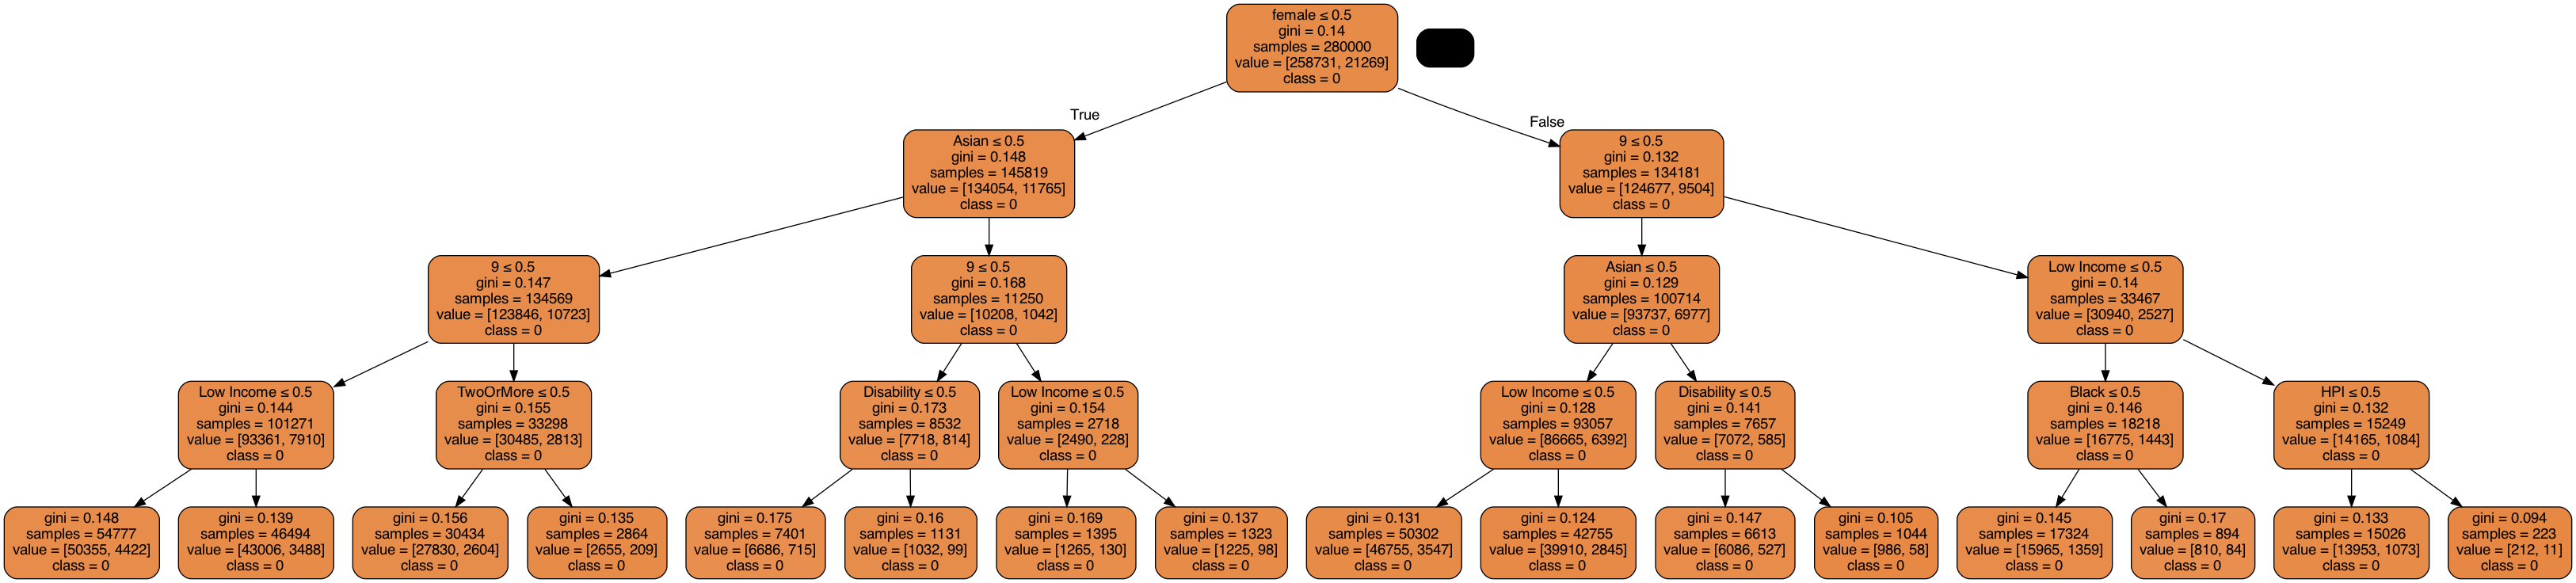

In [72]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = student_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('WA_CS_Students_M3.png')
Image(graph.create_png())

There are two issues with the above image: it is difficult to pick out key indicators and there is a possibility of overfitting. However, if the max_depth or min_samples_split are any less then there are zero students classified as "1" for CS enrollment. We will try a tree with less depth but know that there will only be students classified as "0" in our results. Is there still a way to make this meaningful? Maybe we instead have indicators for not enrolling in CS?

In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9233083333333333


This appears to be a good score, but a confusion matrix will reveal a lot more information about the success of the decision tree classifier.

Confusion matrix

 [[110797      0]
 [  9203      0]]


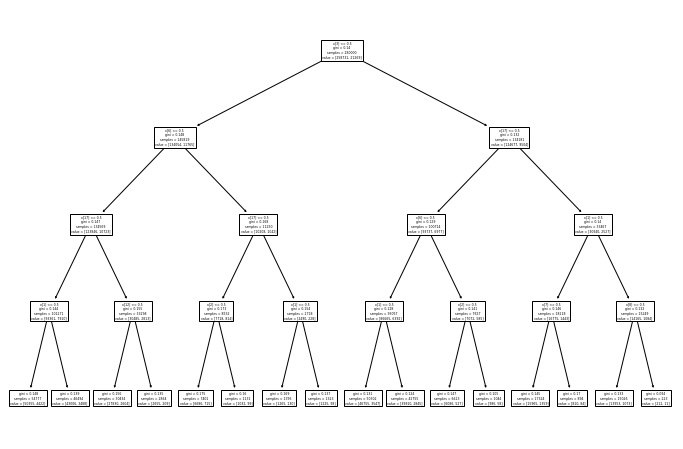

In [74]:

plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(x_train, y_train))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

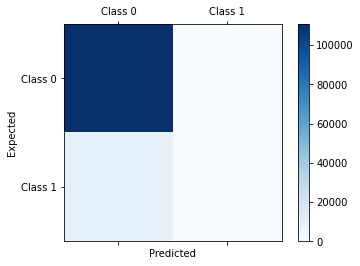

In [75]:


labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Here we can see that the accuracy is actually not great. There are not any false positives and plenty of true positives, but there are quite a few false negatives and zero true negatives. To further help describe what this means in this context:

* true positive: algorithm predicted Class 0 and we expected Class 0
* true negative: algorithm predicted Class 1 and we expected Class 1
* false positive: algorithm predicted Class 1 and we expected Class 0
* false negative: algorithm predicted Class 0 and we expected Class 1

### Imbalanced Classes

Furthermore, it appears that the issue here is that the dataset's classes are imbalanced. If you consider the accuracy score of ~92% and recall that a 7.65% of students were enrolled in CS this imbalance begins to make sense. This has fallen to the [Accuracy Paradox](https://towardsdatascience.com/accuracy-paradox-897a69e2dd9b). What happens is that the algorithm, understandably, decides to just predict one class and voila--high accuracy is acheived because one class is present over 90% of the time! 

To work around this issue we will balance the classes using undersampling methods (undersampling is recommended when a dataset has hundreds of thousands of records). We will undersample with the more simple sample package and then with the imbalanced-learn module.  Then we will test a few different class ratios.

### Undersampling

Looking at the current ratio of this dataset's classes:

Class 0: 369528
Class 1: 30472
Proportion: 12.13 : 1


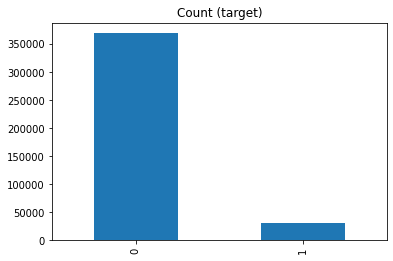

In [76]:
undersample_bisynth = binary_synth.copy(deep=False)


target_count = undersample_bisynth.CS_M3.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [77]:
undersample_bisynth.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Undersampling using the pandas library's sample().

Random under-sampling:
0    30472
1    30472
Name: CS_M3, dtype: int64


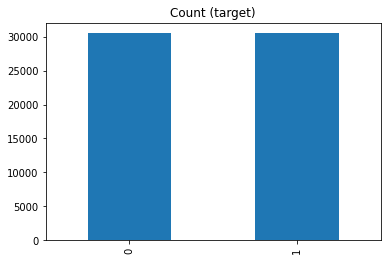

In [78]:
count_class_0, count_class_1 = undersample_bisynth.CS_M3.value_counts()

df_class_0 = undersample_bisynth[undersample_bisynth['CS_M3'] == 0]
df_class_1 = undersample_bisynth[undersample_bisynth['CS_M3'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.CS_M3.value_counts())

df_test_under.CS_M3.value_counts().plot(kind='bar', title='Count (target)');

In [79]:
df_test_under.head()

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9,CS_M3
374214,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
172428,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
394946,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
376959,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
309674,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0


Now, let's try the decision tree again.

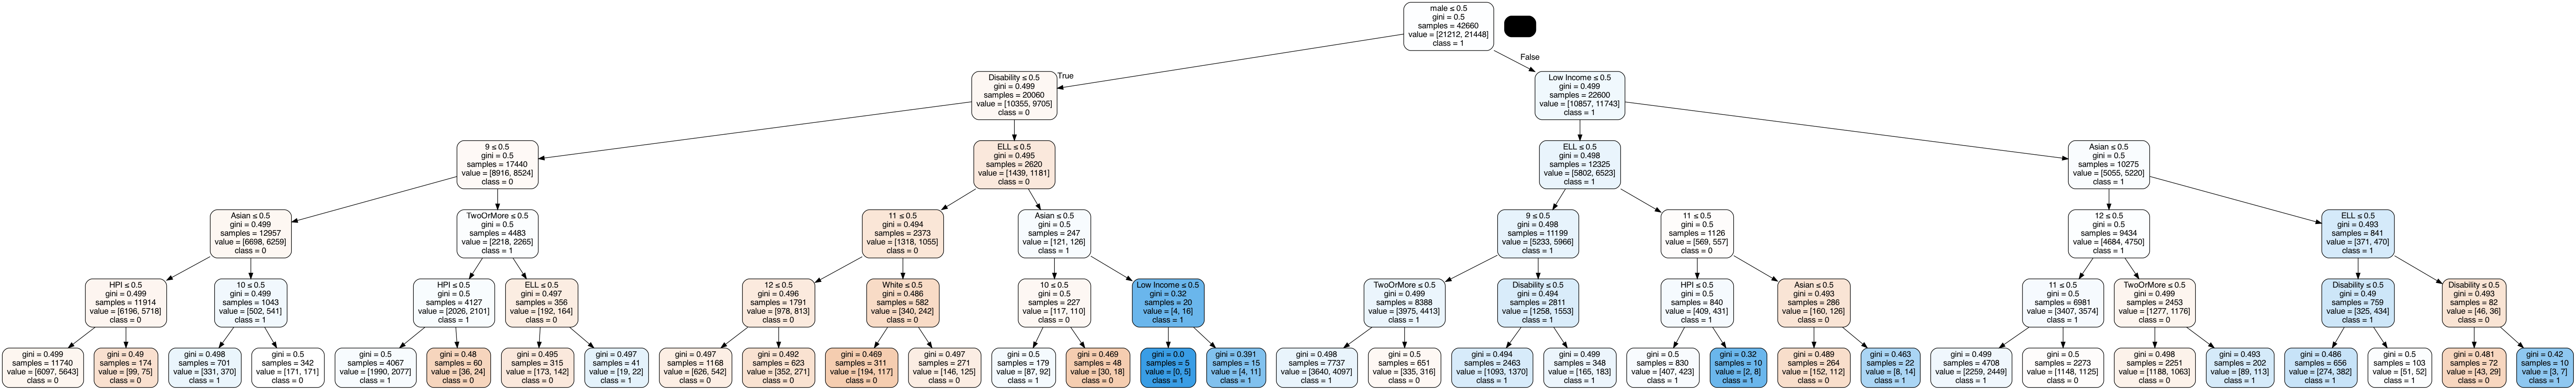

In [80]:
x = df_test_under[student_features]
y = df_test_under.CS_M3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth = 5, min_samples_split = 20)
clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = student_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('WA_CS_Students_under.png')
Image(graph.create_png())

This already looks more promising than the last tree.

In [81]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5211113541894553


Confusion matrix

 [[4664 4596]
 [4160 4864]]


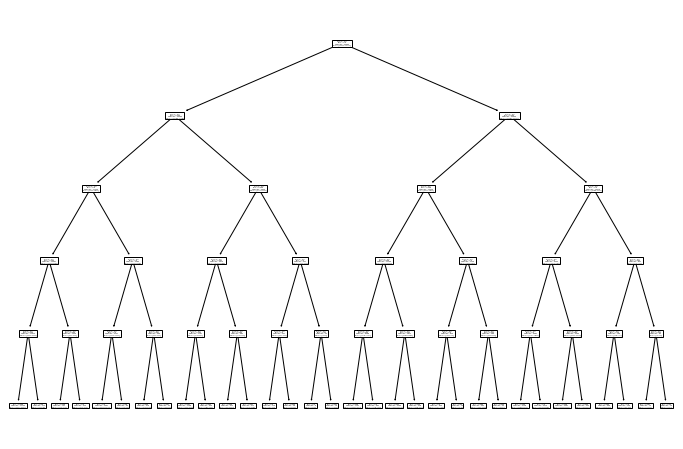

In [82]:
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(x_train, y_train))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

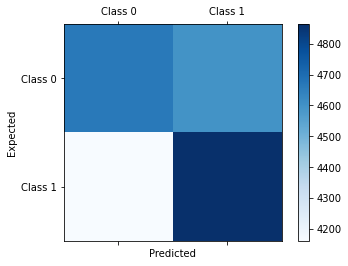

In [83]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

We are hoping for better accuracy than this. One possible way to refine this model is revisiting our undersampling strategy and considering the use of a more advanced module--imbalanced-learn. We can also look back to the data we generated--would generating by school lead to better results?

### Random Forest

In [84]:
x

,ELL,Low Income,Disability,female,male,x,Asian,Black,HPI,Hisp_Lat,NA,Native,TwoOrMore,White,10,11,12,9
374214,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
172428,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
394946,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
376959,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
309674,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399953,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
399961,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
399966,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
399971,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [85]:
y

374214    0
172428    0
394946    0
376959    0
309674    0
         ..
399953    1
399961    1
399966    1
399971    1
399979    1
Name: CS_M3, Length: 60944, dtype: int64

In [86]:
x = df_test_under[student_features]
y = df_test_under.CS_M3

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [87]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.516941504635327


In [88]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9afcc63340>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9a59ee4bb0>})

In [89]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 8, 'n_estimators': 64}


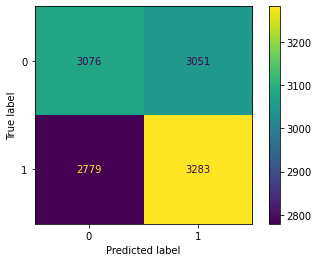

In [90]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [91]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5216998933464599
Precision: 0.5183138616987686
Recall: 0.5415704387990762


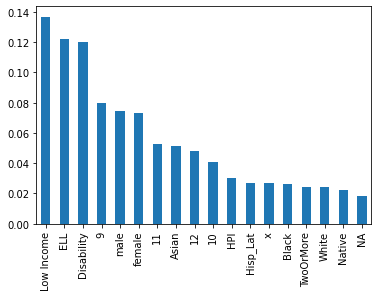

In [92]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

### Correlation Heatmap

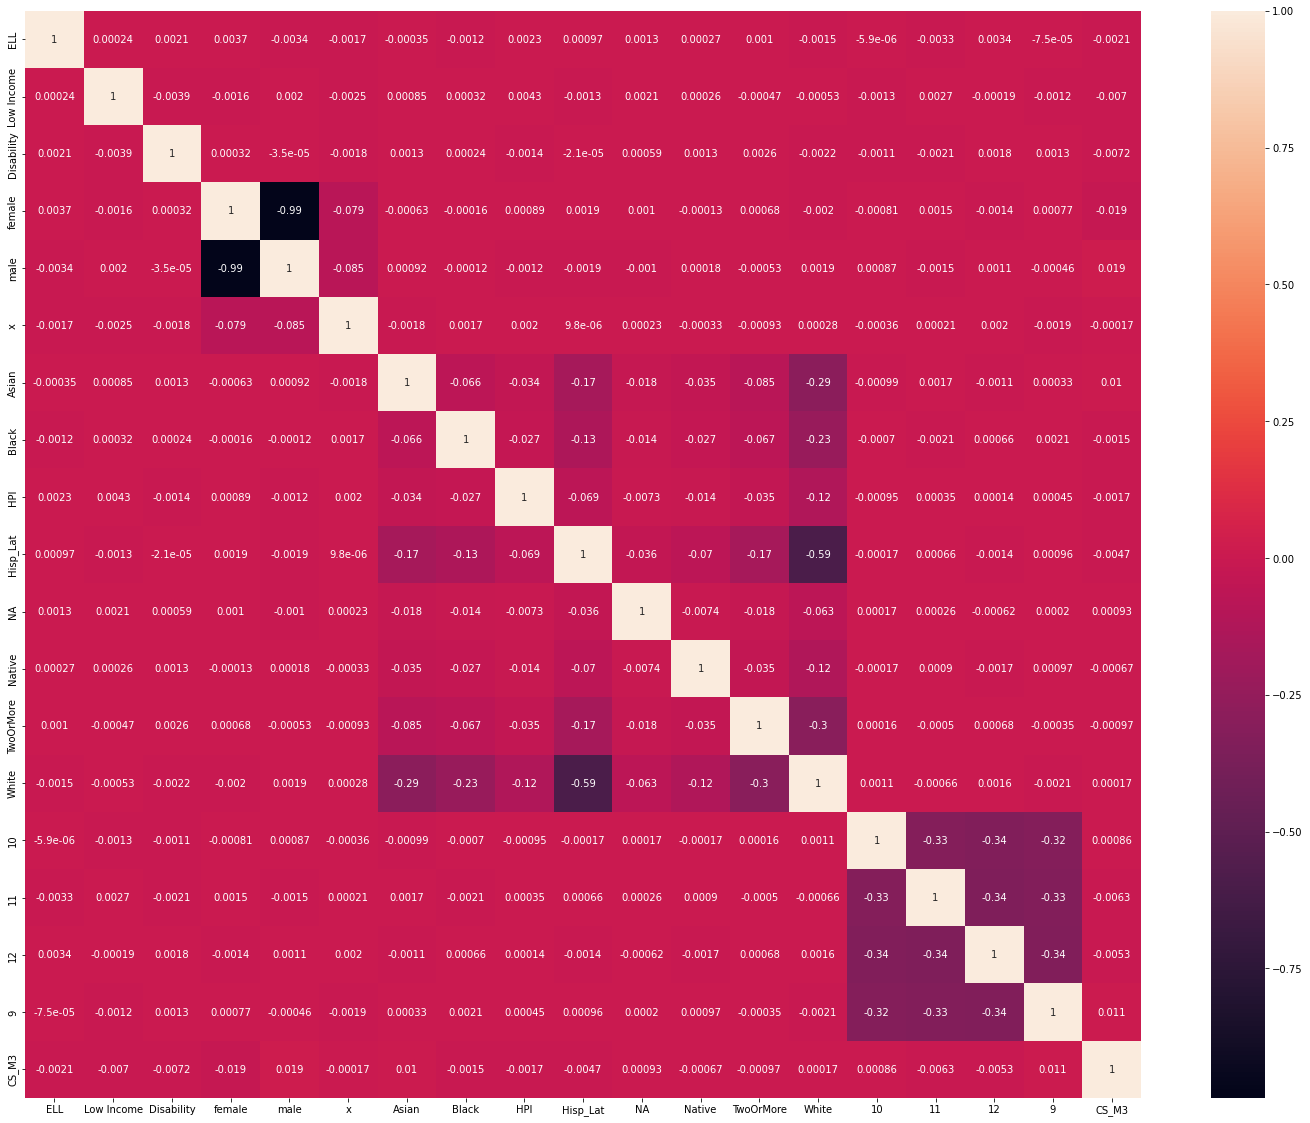

In [93]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(binary_synth.corr(), annot=True)
plt.savefig("Heatmap.png")

### Logistic Regression

In [94]:
bi_synth_features = binary_synth.copy(deep=False)
bi_synth_features = bi_synth_features.drop('CS_M3', axis=1)

X = bi_synth_features
y = pd.Series(binary_synth.CS_M3)

# Make train and test sets
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=2500)

# Train the model
clf_lr.fit(X_train, y_train)

# Make predictions
y_pred = clf_lr.predict(X_test) # Predictions
y_true = y_test # True values

features = list(X_train.columns)
coefficients = clf_lr.coef_[0]

for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")


ELL: -0.030879119991614152
Low Income: -0.054546474946092306
Disability: -0.08464722824731508
female: -0.09411506697258094
male: 0.05194247711723338
x: 0.008690698386780608
Asian: 0.10971681429985418
Black: -0.034553455928719085
HPI: -0.1029466281931048
Hisp_Lat: -0.04436917555947297
NA: 0.10266363961807903
Native: -0.032302414858845434
TwoOrMore: -0.02180329340204959
White: -0.009887377445524315
10: -0.007341179263957055
11: -0.05058266963205624
12: -0.04374774643065652
9: 0.06818970382473749


Eigenvalues:
[1.98657281e+00 1.63587175e+00 1.34683979e+00 1.33148240e+00
 1.32186371e+00 1.18139171e+00 1.08497528e+00 1.05983450e+00
 1.02057429e+00 1.01579882e+00 1.01348990e+00 1.00486908e+00
 1.00348469e+00 9.98169086e-01 9.94827189e-01 4.24050253e-26
 6.25559446e-27 4.79558418e-28]

Variances (Percentage):
[1.10364880e+01 9.08815368e+00 7.48242455e+00 7.39710593e+00
 7.34366891e+00 6.56327087e+00 6.02762540e+00 5.88795474e+00
 5.66984301e+00 5.64331266e+00 5.63048535e+00 5.58259202e+00
 5.57490101e+00 5.54536995e+00 5.52680390e+00 2.35582885e-25
 3.47532157e-26 2.66420677e-27]



Text(0, 0.5, 'Explained variance (%)')

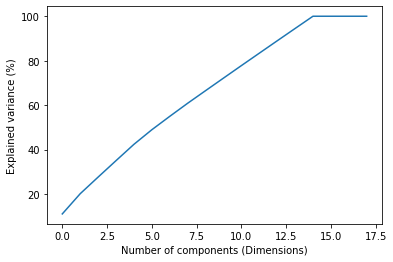

In [95]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

Train accuracy: 0.92
Test accuracy: 0.92

Test confusion_matrix


Text(33.0, 0.5, 'True')

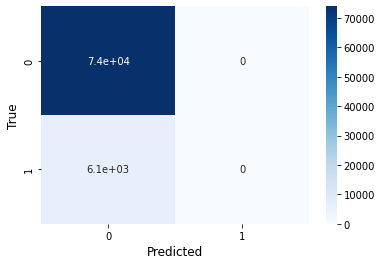

In [96]:
# # Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf_lr.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# # Make the confusion matrix
# from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

Unfortunately this model has also fallen to the accuracy paradox. So we can also re-do the analysis with our undersampled dataset.

In [97]:
X = df_test_under[student_features]
y = df_test_under.CS_M3

# Make train and test sets
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(max_iter=2500)

# Train the model
clf_lr.fit(X_train, y_train)

# Make predictions
y_pred = clf_lr.predict(X_test) # Predictions
y_true = y_test # True values

features = list(X_train.columns)
coefficients = clf_lr.coef_[0]

for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

ELL: -0.05640380966638897
Low Income: -0.05591927799440551
Disability: -0.10069079664369532
female: -0.05883569378314167
male: 0.09018854185772954
x: -0.01959607058637764
Asian: 0.127642076409054
Black: -0.0016774754285457329
HPI: -0.05138377360462302
Hisp_Lat: -0.011718022824675867
NA: -0.03731446667631981
Native: -0.022085159899398406
TwoOrMore: -0.006618093085652947
White: 0.0149116925983698
10: -0.00969695391368188
11: -0.031218530206843714
12: -0.03517427733207867
9: 0.08784653894082266


Train accuracy: 0.52
Test accuracy: 0.52

Test confusion_matrix


Text(33.0, 0.5, 'True')

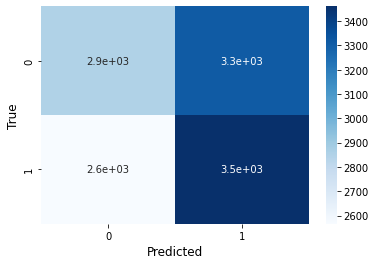

In [98]:
# # Measure accuracy
from sklearn.metrics import accuracy_score
# import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf_lr.predict(X_train)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# # Make the confusion matrix
# from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

## Synthetic students created with consideration to school


### Random Forest

In [101]:
school_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390223 entries, 0 to 390222
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ['Asian']                      390223 non-null  uint8  
 1   ['BIPOC and Not Asian or NA']  390223 non-null  uint8  
 2   ['White']                      390223 non-null  uint8  
 3   school_size                    390223 non-null  float64
 4   school_income                  390223 non-null  float64
 5   male                           390223 non-null  object 
 6   ell                            390223 non-null  object 
 7   low_income                     390223 non-null  object 
 8   disability                     390223 non-null  object 
 9   grade                          390223 non-null  object 
 10  CS_M3                          390223 non-null  int64  
dtypes: float64(2), int64(1), object(5), uint8(3)
memory usage: 24.9+ MB


In [102]:
school_students.head()

,['Asian'],['BIPOC and Not Asian or NA'],['White'],school_size,school_income,male,ell,low_income,disability,grade,CS_M3
0,0,1,0,0.0,0.75,[1],[0],[1],[0],[11],0
1,0,0,1,0.0,0.75,[1],[0],[1],[0],[10],1
2,0,0,1,0.0,0.75,[1],[0],[1],[0],[12],0
3,0,0,1,0.0,0.75,[0],[0],[1],[0],[12],0
4,0,0,1,0.0,0.75,[0],[0],[0],[0],[10],0


In [103]:
school_students['ell'] = school_students['ell'].astype('uint8')
school_students['low_income'] = school_students['low_income'].astype('uint8')
school_students['disability'] = school_students['disability'].astype('uint8')
school_students['male'] = school_students['male'].astype('uint8')
school_students['CS_M3'] = school_students['CS_M3'].astype('uint8')

In [104]:
X = school_students.drop(['CS_M3','grade'], axis = 1)
y = school_students['CS_M3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [211]:
# for i in range(3):
#     tree = rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=X_train.columns,  
#                                filled=True,  
#                                max_depth=2, 
#                                impurity=False, 
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     display(graph)

In [105]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd1260e40d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd1002acf10>})

In [106]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 486}


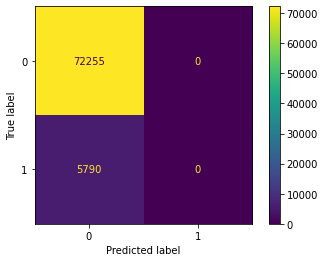

In [107]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [108]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9258120315202768
Precision: 0.0
Recall: 0.0


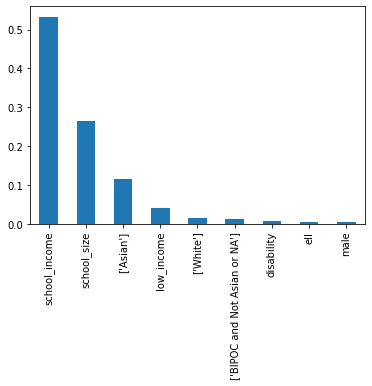

In [109]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Class 0: 361173
Class 1: 29050
Proportion: 12.43 : 1


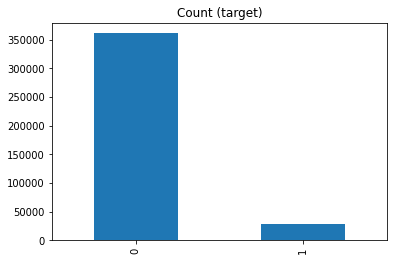

In [110]:
target_count = school_students.CS_M3.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Random under-sampling:
0    29050
1    29050
Name: CS_M3, dtype: int64


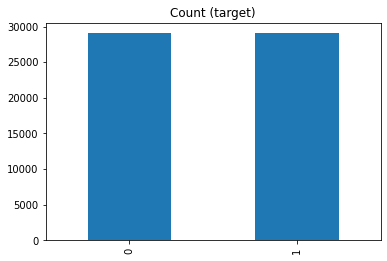

In [111]:
count_class_0, count_class_1 = school_students.CS_M3.value_counts()

df_class_0 = school_students[school_students['CS_M3'] == 0]
df_class_1 = school_students[school_students['CS_M3'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.CS_M3.value_counts())

df_test_under.CS_M3.value_counts().plot(kind='bar', title='Count (target)');

In [112]:
df_test_under

,['Asian'],['BIPOC and Not Asian or NA'],['White'],school_size,school_income,male,ell,low_income,disability,grade,CS_M3
296511,0,1,0,0.5,0.50,0,0,1,0,[11],0
333793,0,1,0,0.5,0.50,1,0,0,0,[10],0
250717,0,0,1,0.5,0.25,1,0,0,1,[9],0
319689,0,1,0,1.0,0.75,0,1,1,0,[12],0
225073,0,1,0,1.0,0.75,1,0,1,0,[9],0
...,...,...,...,...,...,...,...,...,...,...,...
390140,0,0,1,0.0,0.25,0,0,0,0,[10],1
390146,0,1,0,0.0,1.00,0,0,1,0,[11],1
390158,0,1,0,0.0,1.00,0,0,1,0,[12],1
390162,0,0,1,0.0,1.00,1,0,1,0,[12],1


In [113]:
X = df_test_under.drop(['CS_M3','grade','disability','ell'], axis = 1)
y = df_test_under['CS_M3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [114]:
X_train, Xu_test, y_train, yu_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [115]:
from sklearn.model_selection import cross_val_score

In [116]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=10)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd037859a90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd0378139a0>})

In [117]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 13, 'n_estimators': 132}


In [118]:
scores1 = cross_val_score(RandomForestClassifier(n_estimators=5),X, y, cv=10)
print("Avg Score for Estimators=5 and CV=10 :",np.average(scores1))

scores2 = cross_val_score(RandomForestClassifier(n_estimators=20),X, y, cv=10)
print("Avg Score for Estimators=20 and CV=10 :",np.average(scores2))

scores3 = cross_val_score(RandomForestClassifier(n_estimators=30),X, y, cv=10)
print("Avg Score for Estimators=30 and CV=10 :",np.average(scores3))

scores4 = cross_val_score(RandomForestClassifier(n_estimators=40),X, y, cv=10)
print("Avg Score for Estimators=40 and CV=10 :",np.average(scores4))

Avg Score for Estimators=5 and CV=10 : 0.4973838209982788
Avg Score for Estimators=20 and CV=10 : 0.4927538726333907
Avg Score for Estimators=30 and CV=10 : 0.4943029259896729
Avg Score for Estimators=40 and CV=10 : 0.4991049913941481


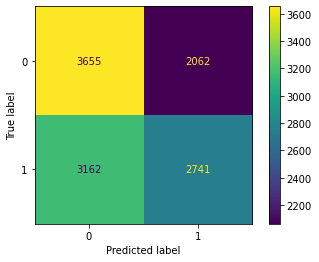

In [119]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [120]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5504302925989673
Precision: 0.5706849885488237
Recall: 0.46434016601727934


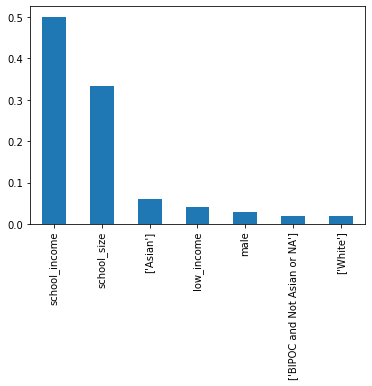

In [121]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

### Correlation Heatmap

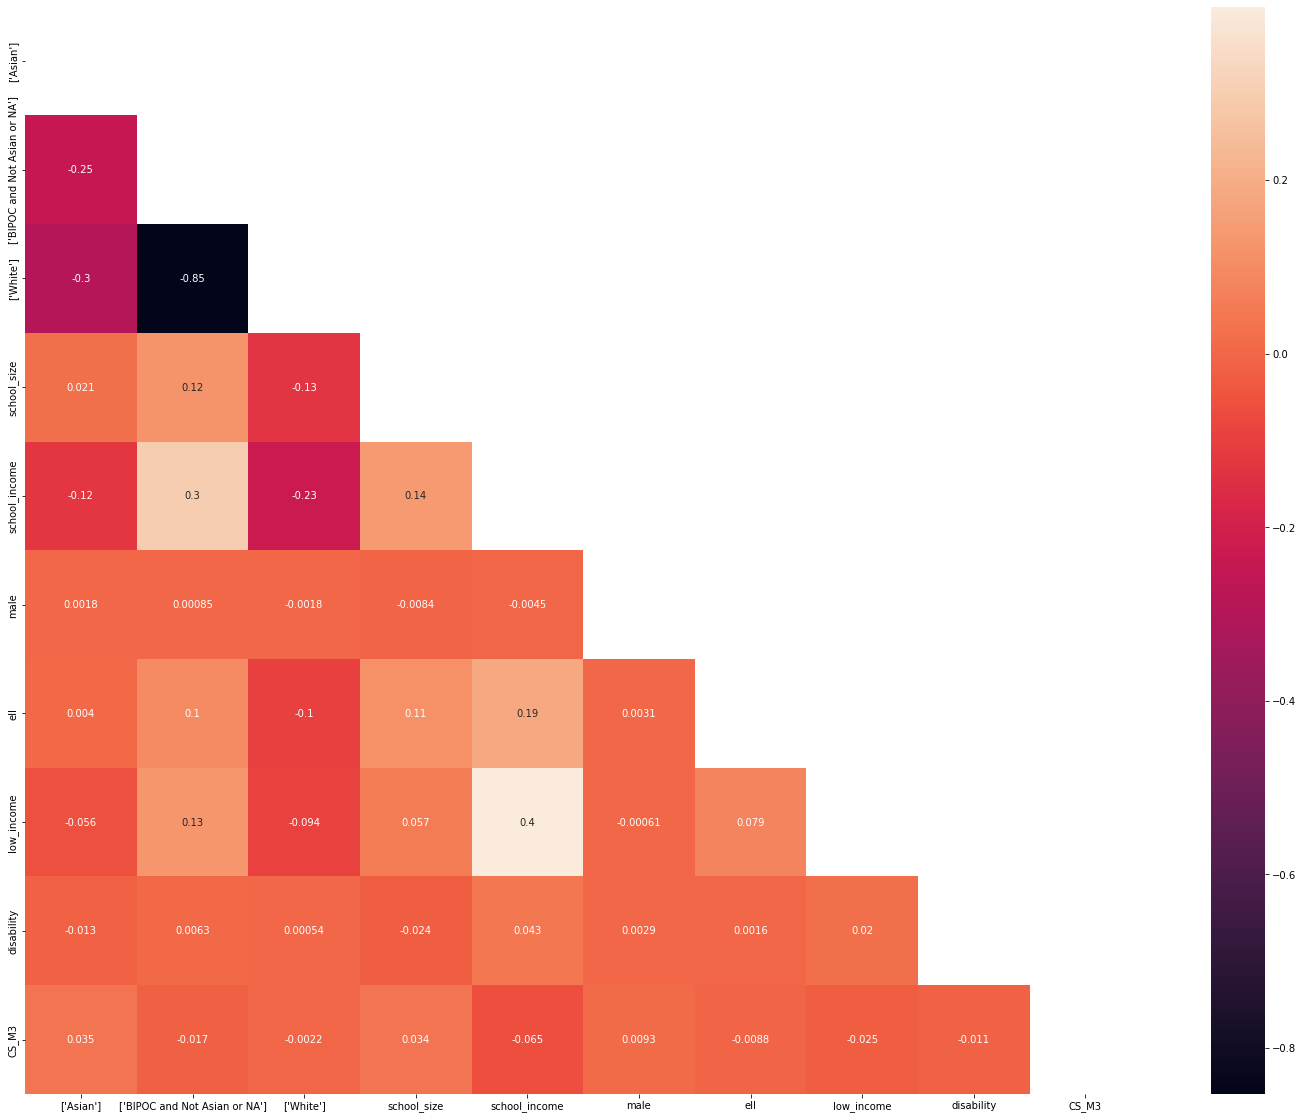

In [122]:
fig = plt.figure(figsize=(25, 20))
corr = school_students.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask)
plt.savefig("Heatmap.png")

## Further Feature Engineering

Feature engineering may be helpful to improve our model. One way to interpret the importance of our features for feature engineering is inspecting the mutual information between our demographic features and our target, CS enrollment.

### Mutual Information

This will tell us more about which features have the most effect on our dependent variable, CS enrollment.

In [123]:
school_students

,['Asian'],['BIPOC and Not Asian or NA'],['White'],school_size,school_income,male,ell,low_income,disability,grade,CS_M3
0,0,1,0,0.0,0.75,1,0,1,0,[11],0
1,0,0,1,0.0,0.75,1,0,1,0,[10],1
2,0,0,1,0.0,0.75,1,0,1,0,[12],0
3,0,0,1,0.0,0.75,0,0,1,0,[12],0
4,0,0,1,0.0,0.75,0,0,0,0,[10],0
...,...,...,...,...,...,...,...,...,...,...,...
390218,0,1,0,0.0,0.50,0,0,1,0,[10],0
390219,0,0,1,0.0,0.50,1,0,1,0,[10],0
390220,0,1,0,0.0,0.50,1,0,0,0,[9],0
390221,0,1,0,0.0,0.50,0,0,0,1,[10],0


In [130]:
X = school_students.drop(['CS_M3', 'grade', 'ell', 'disability'], axis = 1)
y = school_students['CS_M3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [131]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.00174049, 0.03141593, 0.04569579, 0.05422787, 0.01663672,
       0.04600461, 0.03860114])

In [132]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

school_size                      0.054228
male                             0.046005
['White']                        0.045696
low_income                       0.038601
['BIPOC and Not Asian or NA']    0.031416
school_income                    0.016637
['Asian']                        0.001740
dtype: float64

<AxesSubplot:>

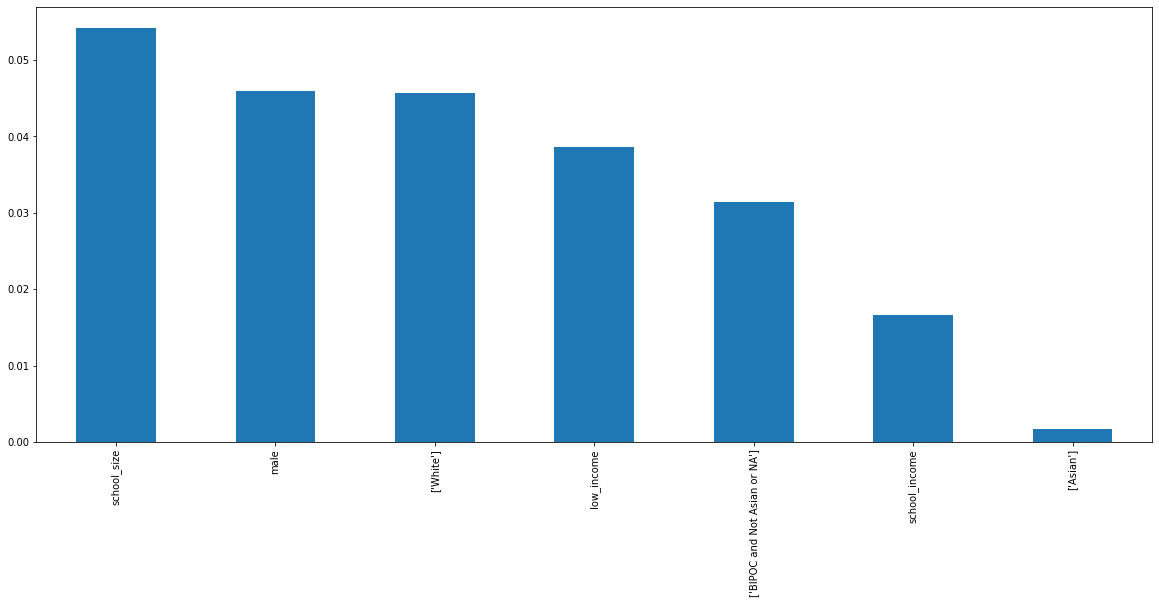

In [133]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

Let's compare this to the feature importance bar chart that resulted from our imperfect random forest model:

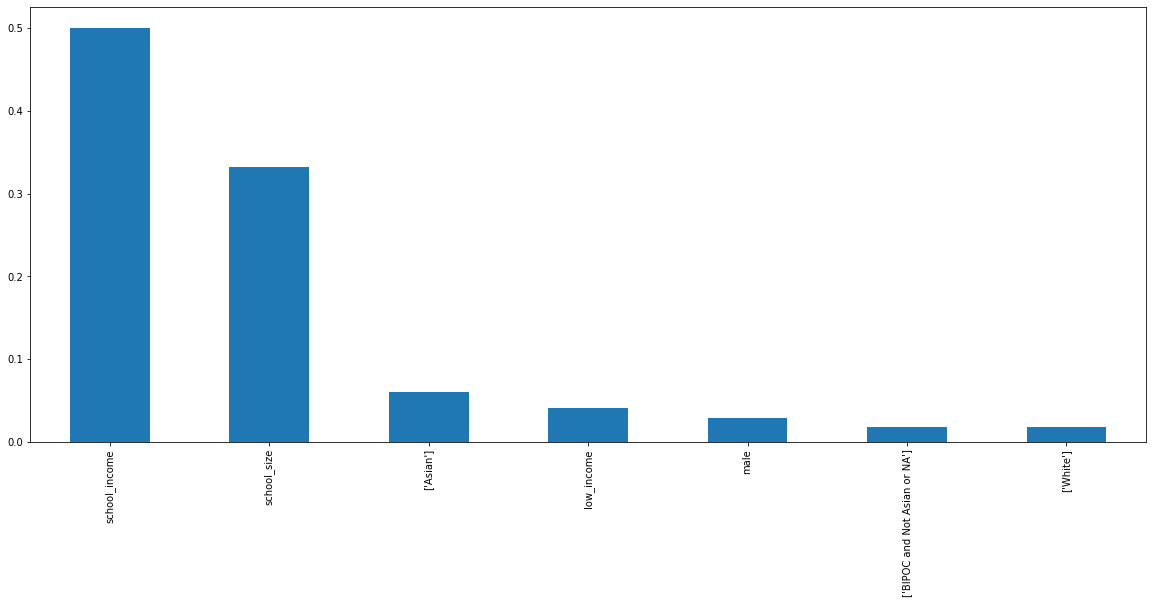

In [129]:
feature_importances.plot.bar(figsize=(20, 8));

This is a curious disparity. There are a few different possible reasons for this:
* These are measures of two different things--mutual information measures the dependency between two variables while random forest feature imporance measures the reduction in impurity.
* The feature importance chart is based on an undersampled data set.

Possible next steps:
* Use a more sophisticated balancing strategy with imbalance-learn package.
* Try using the undersampled data set for mutual importance.
* Create models without the weakest features from both charts or try two different models with only the strongest features from each chart.

Regardless, gender and low income appear to be important features in both of these charts.

It is also possible that the lack of importance of some racial features is because they are not represented as well as white and Asian in the available data. Let's check this assumption:

In [342]:
print(f"White: {Prob_R_White}")
print(f"Hisp_Lat: {Prob_R_Hisp_Lat}")
print(f"TwoOrMore: {Prob_R_TwoOrMore}")
print(f"Asian: {Prob_R_Asian}")
print(f"Black: {Prob_R_Black}")
print(f"HPI: {Prob_R_HPI}")
print(f"Native: {Prob_R_Native}")
print(f"NA: {Prob_R_NA}")

White: 0.5076661293670542
Hisp_Lat: 0.2533448822852574
TwoOrMore: 0.07979539904106114
Asian: 0.07834750898845019
Black: 0.04935383101457372
HPI: 0.013902307142326311
Native: 0.013763924730218362
NA: 0.003826017431058651


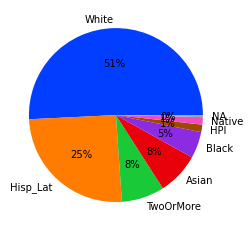

In [343]:
race_probs = [Prob_R_White, Prob_R_Hisp_Lat, Prob_R_TwoOrMore, Prob_R_Asian, Prob_R_Black, Prob_R_HPI, Prob_R_Native, Prob_R_NA]
lables = ['White', 'Hisp_Lat', 'TwoOrMore', 'Asian', 'Black', 'HPI', 'Native', 'NA']
palette_color = sns.color_palette('bright') 
plt.pie(race_probs, labels=lables, colors=palette_color, autopct='%.0f%%')  
plt.show() 

Some of the least important features may be due to this explanation. However, Asian is a smaller proportion of the students than expected. So let's look at the percent enrolled in CS for each racial group.

In [344]:
print(f"White: {Prob_RC_White}")
print(f"Hisp_Lat: {Prob_RC_Hisp_Lat}")
print(f"TwoOrMore: {Prob_RC_TwoOrMore}")
print(f"Asian: {Prob_RC_Asian}")
print(f"Black: {Prob_RC_Black}")
print(f"HPI: {Prob_RC_HPI}")
print(f"Native: {Prob_RC_Native}")
print(f"NA: {Prob_RC_NA}")

White: 0.07235629950076475
Hisp_Lat: 0.06624452514136009
TwoOrMore: 0.07534202582054082
Asian: 0.15484250809537828
Black: 0.06360662547380445
HPI: 0.057327188940092165
Native: 0.04952522807670825
NA: 0.06965840589417281


So it appears that this high percentage, compared to other racial groups (more than double the second highest enrolled racial group, white), is what is making this feature more important in the random forest analysis.